---

<center><b> 개요 </b> : MBTI별 사용 언어를 분석하여 선호 영화 장르를 예측하고 영화 추천 시스템과 결합하여 차별화된 방식으로 영화를 추천 <br><br></center>

---

# <center>EDA 목차</center>

* `Index`
    1. 패키지 불러오기
    2. 데이터 불러오기
        - 2-1. ENFJ 갤러리 크롤링 데이터 소개
        - 2-2. 네이버 영화 리뷰 크롤링 데이터 소개
        - 2-3. 꼬꼬마 프로젝트
        - 2-4. 데이터 전처리
    3. 프로젝트의 이론적 근거
    4. MBTI별 선호하는 영화 장르 구별  
        - 4-1. 사용 알고리즘
        - 4-2. MBTI와 장르 사이의 유사도
        - 4-3. MBTI와 장르 사이의 유사도 시각화
    5. 결과 정리

---

#  <center>1. 패키지 불러오기</center>

---

In [2]:
import pandas as pd
import numpy as np
import os
import sys
from dfply import *
import math
import csv
from konlpy.tag import Kkma
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
import pickle
import os.path
import plotly.offline as pyo
import plotly.graph_objs as go
import spacy
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import matplotlib.pyplot as plt

---

#  <center>2. 데이터 불러오기</center>

---

## ENFJ 갤러리 크롤링 데이터 소개

- num : 게시글 번호

- title : 게시글 제목

- content : 게시글 내용

In [23]:
ENFJ_Crawling = pd.read_csv('./EDA_DATA/enfj.csv', encoding = 'cp949')
ENFJ_Crawling = ENFJ_Crawling.drop(['Unnamed: 0'], axis = 1)

In [24]:
ENFJ_Crawling

,num,title,content
0,5,사랑해요 엔프제,천사가 있다면 당신일 것<U+00A0>
1,6,ㅎㅇ,너희들 다 내 거임
2,7,엔프제 갤러리 특),엔프제는 없고엔프제를 보려는 관객만 있다
3,8,갤주는 갤이름 대문자로 바꿔라. ㅈㄴ 불편하네,NaN
4,9,ㅎㅇㅎㅇ,엔갤 흥하길 바람
...,...,...,...
6837,9659,여태 mbti가 혈액형별 성격 같이 낭설인줄 알았오,enfj 남잔데 제목처럼 mbti가 각혈액형 성격처럼 낭설인줄 알았는데오늘 이런거 ...
6838,9660,엔프제녀들이 얼마나 착하냐면...,엔프제 여사친한테 고백3번하고 다 거절당했음여사친이 나랑 같이 있으면 부담+불편+...
6839,9661,엔프제들아 번호주는거 쉬워?,찐친도아닌데 여기저기 번호 막주고 그래??
6840,9662,아 졸려죽겟는데 할게 너무 많아…,ㅠㅠㅠㅠㅠ최근에 옷장사 시작해서 피팅하고 편집하고 싹다 내가하는데 너무 피곤해ㅐ!!...


## 네이버 영화 리뷰 크롤링 데이터 소개

- content : 영화 리뷰 내용

In [33]:
Movie_Crawling = pd.read_csv('./EDA_DATA/아바타_평점.csv', encoding = 'cp949')

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
Movie_Crawling = Movie_Crawling[['content']]

In [35]:
Movie_Crawling

,content
0,영화사인 한 획을 그은 영화
1,스토리 전개 뻔할지도 몰라요 근데 좋음 스토리 전개 보단 나비 행성에서의 판타지...
2,헐리우드가괜히 헐리우드가 아니다..
3,3D 아이맥스는 진정 최고였다.
4,제임스 카메론 감독 영화는 다 명작인듯
...,...
40806,이게 영화냐? 발로 만들었냐? 돈줘봐 만들어줄게아기공룡 둘리 알지 ? 둘리가 훨씬 ...
40807,역대 과대평가된 영화중 하나진짜 cg가 엄청난것도 아니고 단순히 최신장비로인한 영상...
40808,ㅆㄹㄱ !!!! 지루해
40809,진부한 스토리에 밥맛떨어지게 생긴 3d캐릭터 재미 없는거는 덤


## 꼬꼬마 형태소 분석기

- 꼬꼬마 : 관계형 데이터베이스를 활용한 세종 말뭉치 활용 도구
- 말뭉치를 구조화 하여 데이터베이스에 저장
- 저장된 말뭉치로부터 다양한 통계 데이터를 생성
- 저장된 말뭉치 및 생성된 통계 정보를 다양한 방법으로 조회

In [31]:
kkma = Kkma()

def isNaN(string):
    return string != string
    
os.chdir("./")

data = pd.read_csv("./EDA_DATA/enfj.csv",encoding='CP949')

title = data.title
content = data.content


title_result = []
for i in title:
    check = isNaN(i)
    if check == True:
        continue
    title_part = kkma.nouns(i)
    title_result.extend(title_part)
    
    
content_result = []
count = 0
for i in content:
    check = isNaN(i)
    if check == True:
        continue
    content_part = kkma.nouns(i) 
    content_result.extend(content_part)
    
with open('enfj_TITLE.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(title_result)
   
with open('enfj_CONTENT.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(content_result)

In [37]:
ENFJ_TITLE = pd.read_csv('./EDA_DATA/enfj_title2.csv', encoding = 'cp949')

In [40]:
ENFJ_TITLE.iloc[:,:10]

,사랑,엔,엔프,프,ㅎ,ㅎㅇ,ㅇ,엔.1,엔프제,프.1,...,낭설,줄.24,았오,엔프제녀들.3,면.13,엔프제들.224,번호.1,거.438,얘.35,티.78


In [39]:
ENFJ_CONTENT = pd.read_csv('./EDA_DATA/enfj_contents2.csv', encoding = 'cp949')

In [86]:
ENFJ_CONTENT.iloc[:,:10]

,천사,당신,00,0,너희,내,거,엔프제,없고엔프제,관객


### 데이터 전처리

##### R-Studio 사용

- NA 값 걸러내기
- 동일단어 그룹화
- 단어의 빈도수 계산
- 그룹 해제
- 빈도수에 맞추어 정렬
- 빈도수가 1인 단어 삭제
- 단어의 길이 계산
- 단어의 길이가 1인 경우 삭제
- 단어의 길이 컬럼 삭제

In [18]:
ENFJ_RESULT = pd.read_csv('./EDA_DATA/enfj_result.csv', encoding = 'cp949')
ENFJ_RESULT = DC_Crawling.drop(['Unnamed: 0'], axis = 1)

In [20]:
ENFJ_RESULT.head()

,word,freq
0,사람,2267
1,엔프제,1999
2,생각,1484
3,친구,1316
4,내가,1043


---

#  <center>3. 프로젝트의 이론적 근거</center>

---

<img src="./MBTI 그림2.PNG"  width="700" height="370">

<img src="./MBTI 그림1.PNG"  width="700" height="370">

## 결론 : MBTI별로 자주 사용하는 단어를 구분 지을 수 있다.

---

# 4. MBTI별 영화 장르 구분

---

## 사용 알고리즘
- TfidfVectorizer
 - 단어의 빈도와 역 문서 빈도를 사용하여 DTM 내의 각 단어들마다 중요한 정도를 가중치로 주는 방법
 - DTM : 단어의 빈도수를 Matrix로 표현
- LinearSVC
 - 주어진 데이터가 어느 카테고리에 속할지 판단하는 이진 선형 분류 모델
 - 직선과 가장 가까이 있는 점들을 Support Vector 라고 하고, 찾은 직선과 서포트벡터 사이의 거리를 최대로 하는 서포트벡터와 직선을 찾는 것이 목표

In [ ]:
# INTP 데이터 전처리
INTP_c = pd.read_csv(('./MBTI_Crawling/INTP_content.csv'), encoding='cp949', header=None)
INTP_t = pd.read_csv(('./MBTI_Crawling/INTP_title.csv'), encoding='cp949', header=None)
INTP2_c = pd.read_csv(('./MBTI_Crawling/INTP2_content.csv'), encoding='cp949', header=None)
INTP2_t = pd.read_csv(('./MBTI_Crawling/INTP2_title.csv'), encoding='cp949', header=None)
INTP_c = INTP_c.transpose()
INTP_t = INTP_t.transpose()
INTP2_c = INTP2_c.transpose()
INTP2_t = INTP2_t.transpose()
INTP = pd.concat([INTP_c,INTP_t,INTP2_c,INTP2_t], axis=0)
INTP.reset_index(drop=True, inplace=True)

INTP = INTP.iloc[:15000]
INTP_list =[]
for a in range(1500):
    word = str(INTP[0][0+a*10])+" "+str(INTP[0][1+a*10])+" "+str(INTP[0][2+a*10])+" "+str(INTP[0][3+a*10])+" "+str(INTP[0][4+a*10])+" "\
          +str(INTP[0][5+a*10])+" "+str(INTP[0][6+a*10])+" "+str(INTP[0][7+a*10])+" "+str(INTP[0][8+a*10])+" "+str(INTP[0][9+a*10])+" "
    INTP_list.append(word)
INTP_word = pd.DataFrame()
INTP_word['posts'] = INTP_list
INTP_word['type'] = INTP_word['posts'].apply(lambda x:'INTP')
INTP = INTP_word

# MBTI별 데이터셋 MBTI으로 통합
MBTI = pd.concat([INFP,INTP,ISFP,ISTP,ENFP,ENTP,ESFP,ESTP,ENFJ,ENTJ,ESFJ,ESTJ,ISTJ,ISFJ,INFJ,INTJ], axis=0)
# [INFP,INTP,ISFP,ISTP],[ENFP,ENTP,ESFP,ESTP],[ENFJ,ENTJ,ESFJ,ESTJ],[ISTJ,ISFJ,INFJ,INTJ]
# MBTI를 column에 따라 분할
MBTI_type =  MBTI['type']
MBTI_posts = MBTI['posts']

# # dataframe을 csv파일로 저장
MBTI.to_csv('./MBTI_통합본.csv')
MBTI.shape

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(MBTI_posts, MBTI_type,
                                                   test_size=0.2)
  
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(MBTI_posts, MBTI_type,
                                                   test_size=0.2)

# Check if need to recreate the model
if recreate_model:    
    
    # Creating an instance to vectorizer:
    vectorizer = TfidfVectorizer()
    
    # Training the vectorizer:
    x_train_tfidf = vectorizer.fit_transform(x_train)
    
    # Training the classifier:
    clf = LinearSVC()
    clf.fit(x_train_tfidf, y_train)
    
    # Pipelining the vectorizer and the classifier
    text_clf = Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC())])
    text_clf.fit(x_train, y_train)
    
    # saving the model to disk
    pickle.dump(text_clf, open(filename, 'wb'))

# If there is no need to recreate the model, just open the file from the disk    
else:
    # loading the model from disk
    text_clf = pickle.load(open(filename, 'rb'))

predictions = text_clf.predict(x_test)

print(classification_report(y_test, predictions))

# 판타지
fantasy = pd.read_csv('./Naver_Movie_Review_Combination/Fantasy_Combination.csv', encoding='utf-8', index_col=0)
# fantasy = fantasy.transpose()
# fantasy.rename(columns = {0:'posts'},inplace=True)
fantasy['Word'] = fantasy['Word'].astype(str)
fantasy_test = fantasy['Word']
predictions = text_clf.predict(fantasy_test)
predictions = predictions.tolist()

# 로맨스
romance = pd.read_csv('MBTI-romance.csv', encoding='cp949', header=None)
romance = romance.transpose()
romance.rename(columns = {0:'posts'},inplace=True)
romance['posts'] = romance['posts'].astype(str)
romance_test = romance['posts']
predictions = text_clf.predict(romance_test)
predictions = predictions.tolist()

print('INTP : ' + str((predictions.count('INTP')/(
       predictions.count('INTP')+predictions.count('INFP')+
       predictions.count('ISTP')+predictions.count('ISFP')+
       predictions.count('ESTJ')+predictions.count('ESFJ')+
       predictions.count('ENTJ')+predictions.count('ENFJ')+
       predictions.count('ESFP')+predictions.count('ESTP')+
       predictions.count('ENFP')+predictions.count('ENTP')+
       predictions.count('ISTJ')+predictions.count('ISFJ')+
       predictions.count('INFJ')+predictions.count('INTJ'))
      )*100) + '%')

<img src="./그림4.png"  width="400" height="200" align="left">

## MBTI와 장르 사이의 유사도

- LinearSVC 로 생성된 모델로 구한 MBTI 와 장르 사이의 유사도 값

In [ ]:
filename = 'MBTI_svm_v2.sav'
text_clf = pickle.load(open(filename, 'rb'))

# SF
SF = pd.read_csv('./EDA_DATA/SF_Combination.csv', encoding='utf-8', index_col=0)
SF['Word'] = SF['Word'].astype(str)
SF_test = SF['Word']
predictions_SF = text_clf.predict(SF_test)
predictions_SF = predictions_SF.tolist()

# 호러
horror = pd.read_csv('./EDA_DATA/Horror_Combination.csv', encoding='utf-8', index_col=0)
horror['Word'] = horror['Word'].astype(str)
horror_test = horror['Word']
predictions_horror = text_clf.predict(horror_test)
predictions_horror = predictions_horror.tolist()

def MBTI_Movie_Preference(x):
  Genre_list = ['fantasy','romance','horror','SF','drama','action','thriller','comedy']
  for genre in Genre_list:
        print(x+'-'+'{}'.format(genre)+' : ' + str(round(eval('predictions_'+'{}'.format(genre)).count(x)/(predictions_fantasy.count(x) + predictions_romance.count(x)\
                                                           + predictions_horror.count(x) + predictions_SF.count(x)\
                                                           + predictions_drama.count(x) + predictions_action.count(x)\
                                                           + predictions_thriller.count(x) + predictions_comedy.count(x))*100,2)
                            ) + "%"
  )
  
MBTI_Movie_Preference('INTP')
print('\n')
MBTI_Movie_Preference('INFP')
print('\n')
MBTI_Movie_Preference('ISFP')
print('\n')
MBTI_Movie_Preference('ISTP')
print('\n')
MBTI_Movie_Preference('ENFP')
print('\n')
MBTI_Movie_Preference('ENTP')
print('\n')
MBTI_Movie_Preference('ESFP')
print('\n')
MBTI_Movie_Preference('ESTP')
print('\n')
MBTI_Movie_Preference('ENFJ')
print('\n')
MBTI_Movie_Preference('ENTJ')
print('\n')
MBTI_Movie_Preference('ESFJ')
print('\n')
MBTI_Movie_Preference('ESTJ')
print('\n')
MBTI_Movie_Preference('INFJ')
print('\n')
MBTI_Movie_Preference('INTJ')
print('\n')
MBTI_Movie_Preference('ISFJ')
print('\n')
MBTI_Movie_Preference('ISTJ')
print('\n')

<img src="./그림3.PNG"  width="200" height="50" align="left">

## MBTI와 장르 사이의 유사도 시각화

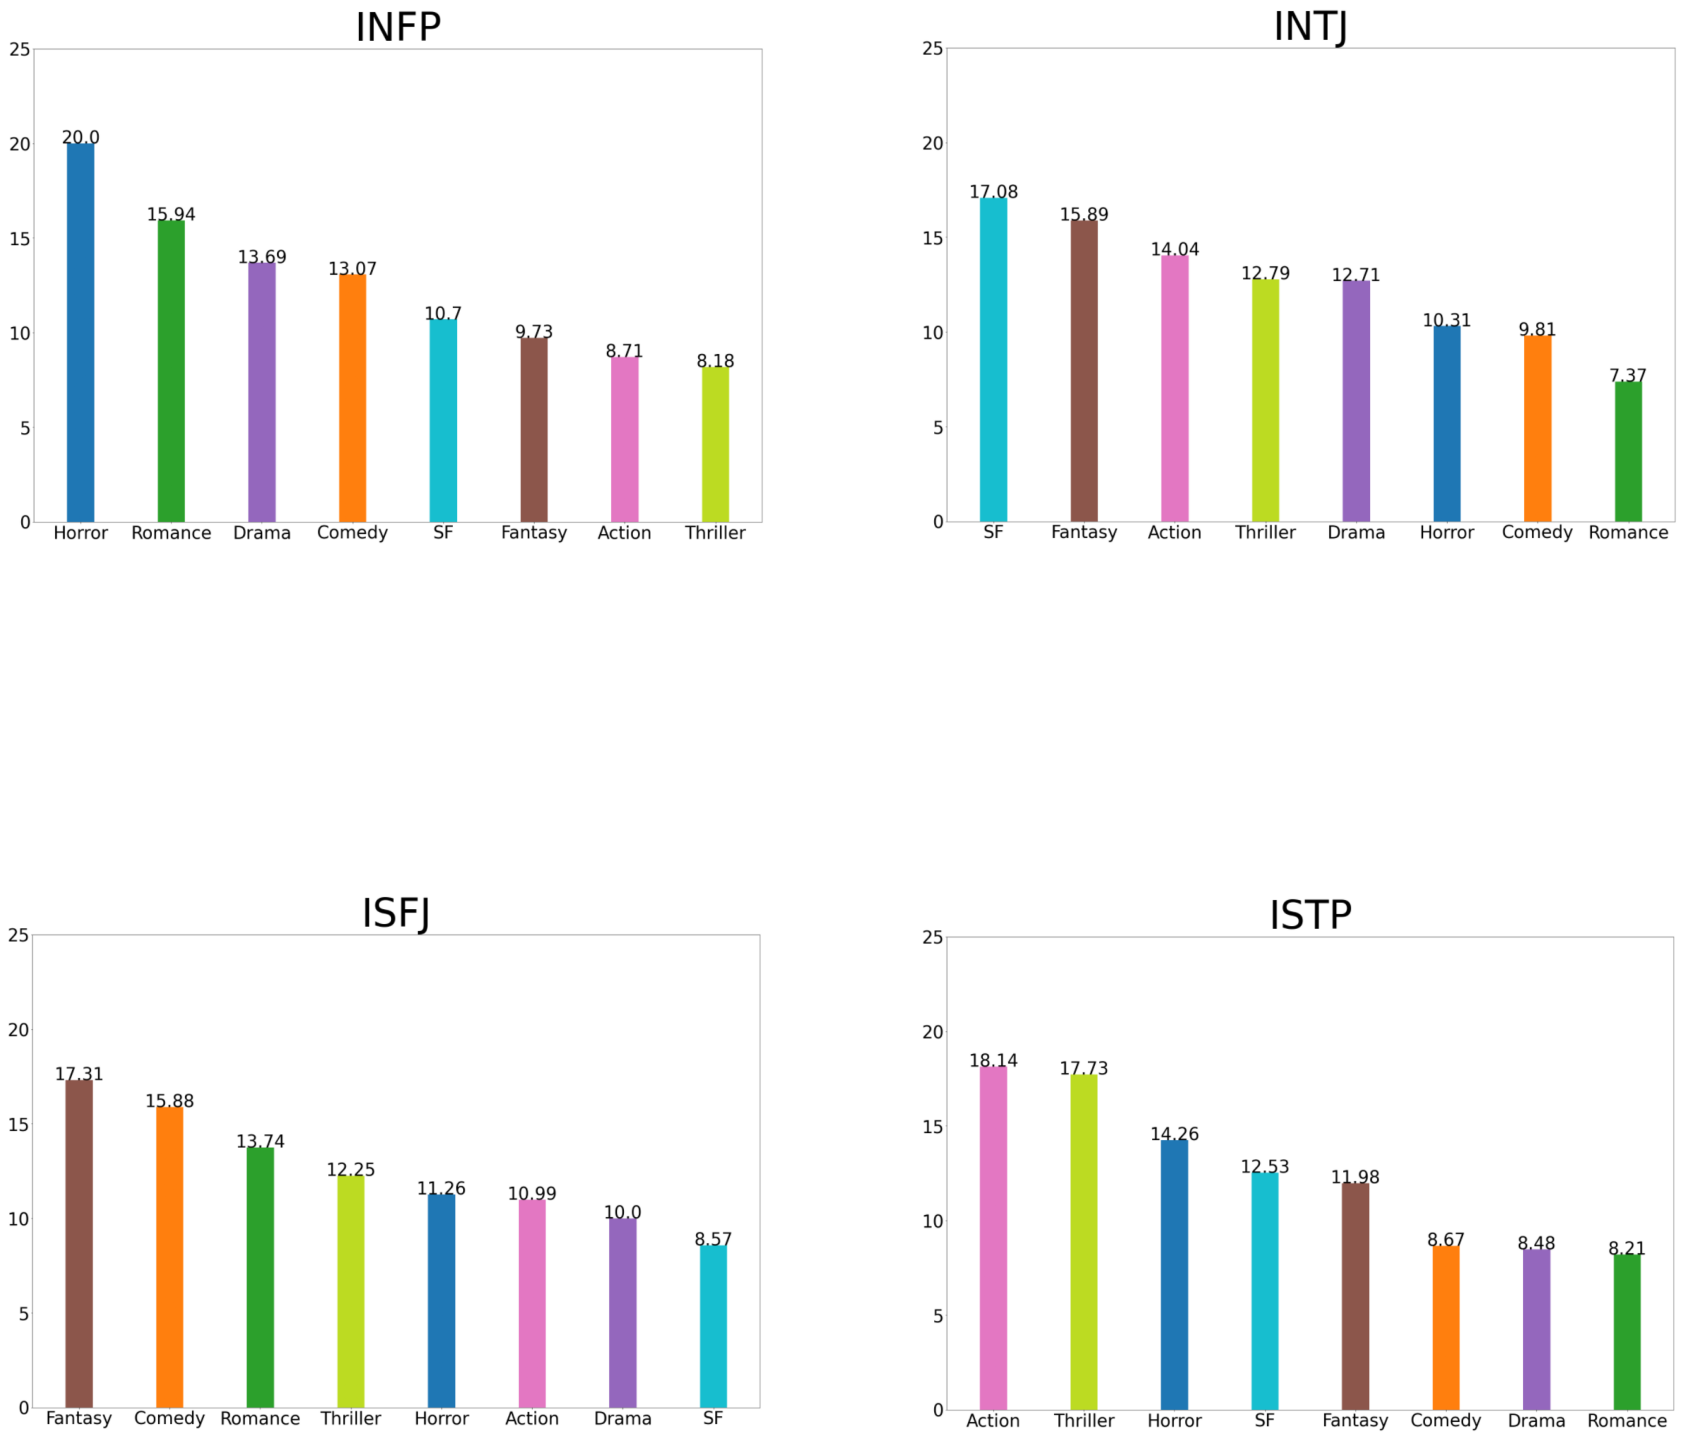

In [85]:
plt.figure(figsize=(30,30))

image1 = plt.imread('./EDA_IMAGE/그림10.png')
image2 = plt.imread('./EDA_IMAGE/그림11.png')
image3 = plt.imread('./EDA_IMAGE/그림12.png')
image4 = plt.imread('./EDA_IMAGE/그림13.png')

plt.subplot(221)
plt.axis('off')
plt.imshow(image1)

plt.subplot(222)
plt.axis('off')
plt.imshow(image2)

plt.subplot(223)
plt.axis('off')
plt.imshow(image3)

plt.subplot(224)
plt.axis('off')
plt.imshow(image4)

plt.show()

---

# 5. 결과 정리

-----

#### 1. MBTI별로 자주 사용하는 단어가 다름을 알 수 있다.
#### 2. 영화 장르별로 자주 사용되는 단어를 구분 지을 수 있다.
#### 3. 데이터간의 유사도를 계산하여 MBTI를 추론할 수 있다.
#### 4. MBTI별로 선호하는 영화 장르가 다르다.
